### Everything we need to import

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from itertools import combinations
import networkx as nx
from bs4 import BeautifulSoup, Comment
import requests

### Define functions to scrape Basketball-Reference lineup data and create/draw Player Pair Net Point Graphs

In [5]:
def get_soup(url):
    '''
    Parses page located at specified url into a "soup" of html content readable in python
    
    Given:
        url, string of webpage location
    Returns:
        the "soup" (python-compatible objects) of the html parsed webpage content collected and read thru
        requests
    '''
    response = requests.get(url)
    page = response.text
    return BeautifulSoup(re.sub('<!--|-->', '', page), 'html5lib')
    
def get_lineup_info(teampg_url, n_combo):
    '''
    For a team, gets lineup-by-lineup statistics for each individual combination of n_combo (a value in
    (2,5)) players
    
    Given:
        teampg_url, a string giving the url of the Basketball-Reference page for a team for a given season
        n_combo, an integer specifying the level of lineup combination (2, 3, 4, or 5 players)
    Return:
        df, a dataframe of the team's statistics for each possible n_combo lineup of players     
    '''
    
    # Parse the team/season's lineup page
    main_url = teampg_url + '/lineups'    
    soup = get_soup(main_url)
    
    # Find the table with all n_combo man lineups
    tbl_string = 'lineups_' + str(n_combo) + '-man_'
    tbl = soup.find('table', {'id': tbl_string})
    
    # Create dictionary whose keys are the lineup combination and values are all the statistics from the
    # table, then convert to a dataframe
    d = {}
    rows=[row for row in tbl.find_all('tr')]
    for row in rows[:-1]:
        items = row.find_all('td')
        try:
            comb = items[0].text
            d[comb] = [j.text.strip() for j in items[1:]]
        except:
            continue
    df = pd.DataFrame.from_dict(d, orient='index')
    df.columns = [k.text for k in rows[1].find_all('th')][2:]
    return df

def get_teamseason_basics(teamseason_url):
    '''
    For a team (for a given season), gets the "basics", the information located at the top of that team's
    Basketball-Reference page (example right below the "Previous Season" button: https://www.basketball
    reference.com/teams/TOR/2019.html)
    
    Given:
        teamseason_url, a string giving the url of the page for a team for a given season
    Return:
        a dictionary of the "basics" for the team for the given season (keys are name of the basic
        attribute, and values are the value of each attribute)
    '''
    
    # Parse the team/season page
    soup = get_soup(teamseason_url)
    
    # Get all content included in "basics" and convert into dict format
    pars = [p.text for p in soup.find_all('p')]
    pars = [re.split(': | \s' , b.strip().replace('\n', '')) for b in pars[2:10]]
    pars = [re.sub(r'\([^)]*\)', '', a.strip()) for b in pars for a in b if a and 'Division' not in a and 'Conference' not in a]
    pars = [re.sub(r'\,.+', '', b) for b in pars]
    return {pars[2*n]: pars[2*n+1] for n in range(int(len(pars)/2)-1)}

def convert_bbref_mp(mp):
    '''
    Converts minutes played from lineup pages (given as a string mm:ss format) into total minutes
    
    Given:
        mp, a string given the minutes played by a given lineup combination (as mm:ss)
    Returns:
        the float value of mp in total minutes 
    '''
    
    mins, secs = [int(x) for x in mp.split(':')]
    return mins + (secs/60)

def get_est_net_pts(mp, pts, pace):
    '''
    Attempts to adjust net points from lineup pages to an absolute net value, based on pace as
    number of possessions per 48 minutes and the net points as a per 100 possessions measure
    
    Given:
        mp, a float giving the number of minutes played by a team's lineup
        pts, a float giving the number of net points per 100 possessions of a team's lineup
        pace, a float giving the number of possessions per 48 minutes of the team
    Return:
        a float        
    '''
    
    mp = mp/48 # to convert pace to possession per minutes
    pts = pts/100 # points per possession
    return pace * mp * pts

def make_graph(team, season):
    '''
    Creates network graph object for a given team for a given season. Nodes of the graph object are the
    players on the team for that season. Edges reflect the time a player pair were on the court together.
    The weight of each edge is the estimated net points for this player pair (colored red if negative,
    black if positive)
    
    Given:
        team, a string for the given team name
        season, an integer for the given season
    Return:
        G, a Networkx graph as described above
    '''
    
    # get the season page for the given team and get stats for all 5-man lineup combos (and convert
    # minutes played to total minutes) 
    url = 'https://www.basketball-reference.com/teams/' + team + '/' + str(season)
    lineups_5man = get_lineup_info(url, 5)
    lineups_5man['MP2'] = lineups_5man['MP'].apply(convert_bbref_mp)
    
    # collect into a list of tuples where each tuple is a 5 player combination and its number of minutes
    # played and net points per 100 poss
    player_5man = [sorted((x[0].strip(), x[1].strip(), x[2].strip(), x[3].strip(), x[4].strip())) for x in lineups_5man.index.str.split('|')]
    wgtd_player_5man = [tuple(list(player_5man[p]) + [lineups_5man.iloc[p]['MP2']] + [float(lineups_5man.iloc[p]['PTS'])]) for p in range(len(player_5man))]
    
    # get all unique player pairs and create a dict of estimated net points for each of these pairs 
    players = set([y for x in player_5man for y in x])
    all_player_pairs = list(combinations(players, 2))
    player_pair_dict = dict.fromkeys(all_player_pairs, 0)
    
    # get the "basics" for the given team and season, particularly the pace
    teamseason_basics = get_teamseason_basics(url + '.html')
    pace = float(teamseason_basics['Pace'])
    
    # iterate through all lineup combinations and calculate the estimated net points for each player pair
    # keep only those pairs which are not zero (right now assumes cumulative net points over all lineups
    # won't add up to zero -- need to modify)
    for j in wgtd_player_5man:
        combs = list(combinations(j[:-2], 2))
        for comb in combs:
            try:
                player_pair_dict[comb] += get_est_net_pts(j[-2], j[-1], pace)
            except:
                player_pair_dict[tuple(reversed(comb))] += get_est_net_pts(j[-2], j[-1], pace)
    player_pair_dict = {k: v for k, v in player_pair_dict.items() if v != 0}
    
    # create graph object from the player pairs and their estimated net point values
    G = nx.Graph()
    G.add_weighted_edges_from([(k[0], k[1], v) for k,v in player_pair_dict.items()])
    for u,v in G.edges():
        G[u][v]['color'] = 'red' if G[u][v]['weight'] < 0 else 'black'
    return G

def get_graph_layout(graph):
    '''
    Create layout of graph object (and its node labels) when drawn. The graph will be displayed in a circular layout 
    (nodes arranged in a circle)
    
    Given:
        graph, a Networkx graph object
    Return:
        pos, a dict of tuples corresponding to the x and y positions of each node
        pos_off, a dict of tuples corresponding to the x and y positions of each node label
    '''
    
    # get intiial layout
    pos = nx.circular_layout(graph)
    
    # shift all nodes with a "non negative" x to the right, otherwise to the left
    pos_off = {}
    for k, v in pos.items():
        if v[0] >= -.000001:
            pos_off[k] = (v[0] + 0.15, v[1])
        else:
            pos_off[k] = (v[0] - 0.15, v[1])
    return pos, pos_off

def draw_graph(graph):
    '''
    Given:
        graph, a Networkx graph object
    Returns:
        Drawing of 'graph' in a circular layout, with specified node labels (does not actually return a specific value)
    '''
    
    # Create figure
    plt.figure(figsize=(10,8))
    
    # Get positions of graph nodes and node labels
    g_layout, lbl_layout = get_graph_layout(graph)
    
    # Draw the graph and node labels
    nx.draw(graph, pos=g_layout, width=[0.025*graph[u][v]['weight'] for u,v in graph.edges()], edge_color=[graph[u][v]['color'] for u,v in graph.edges()])
    nx.draw_networkx_labels(graph, pos=lbl_layout)
    
    # 
    cut = 1.1
    xmax= cut*max(xx for xx,yy in lbl_layout.values())
    ymax= cut*max(yy for xx,yy in lbl_layout.values())
    plt.xlim(-xmax,xmax)
    plt.ylim(-ymax,ymax)
    plt.show()

### Let's check out what these look like for a few teams:

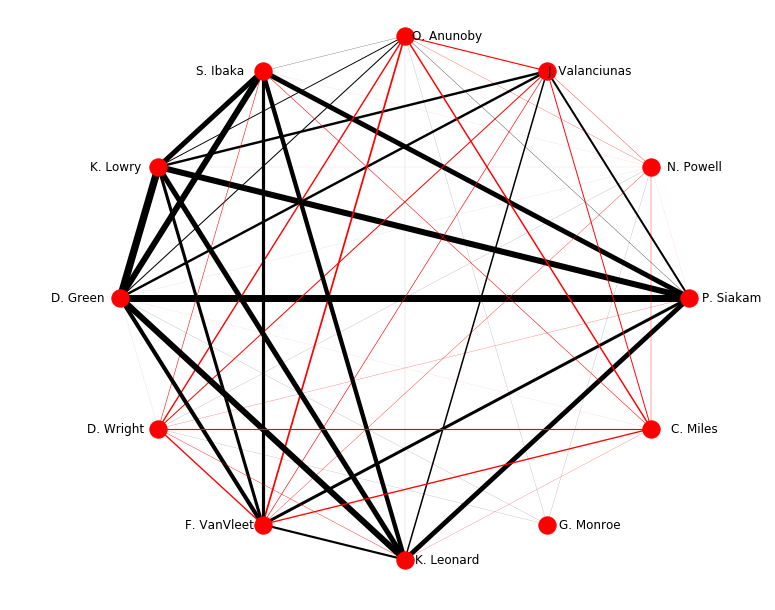

In [6]:
Raptors_18_19 = make_graph('TOR', 2019)
draw_graph(Raptors_18_19)

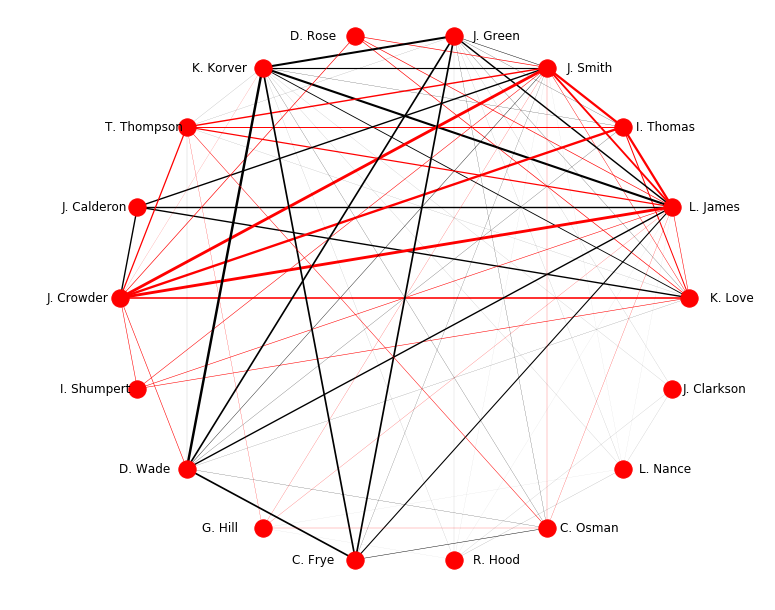

In [7]:
Cavs_17_18 = make_graph('CLE', 2018)
draw_graph(Cavs_17_18)

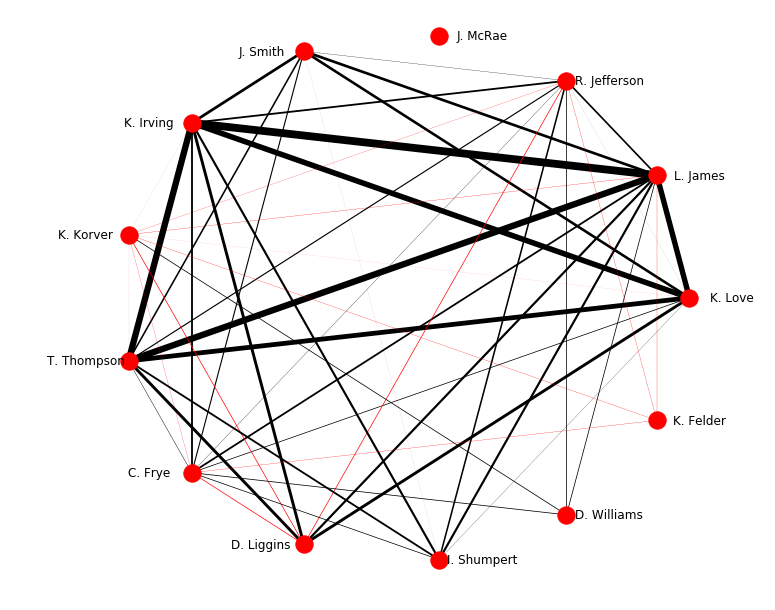

In [9]:
Cavs_16_17 = make_graph('CLE', 2017)
draw_graph(Cavs_16_17)